# Entropy labelling learning

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

import time

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [496]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

orig_S = 2000
lim_S1 = 25*3
lim_S2 = lim_S1*2

In [497]:
# entropy labelling
def ent_label(probas):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    temp_labels = [i for i, Ipk in enumerate(info_con) if Ipk <= Hp]

    paddings = np.full(10 - len(temp_labels), np.nan)
    return np.concatenate((temp_labels, paddings), axis = 0)

In [498]:
# generate an annotator
modelS = LR().fit(train_imgs[orig_S:orig_S*2], train_labels[orig_S:orig_S*2])
s_proba = modelS.predict_proba(test_imgs[lim_S1:lim_S1 + lim_S2])

# entropy labelling
mul_labels = [ent_label(probas) for i, probas in enumerate(s_proba)]

In [499]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup  
    
dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(test_imgs[lim_S1:lim_S1 + lim_S2])])

d_imgs = []
    
for img in dupld_imgs:
    a = img.shape
    n = a[0]
    if (n == 784):
        d_imgs.append(img)
    else:
        for _ in range(n):
            d_imgs.append(img[0])
            
d_imgs = np.array(d_imgs)

### ravelling mul_labels

In [500]:
def extract_labels(labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    return labels[:k]

mul_labels = [extract_labels(labels) for labels in mul_labels]

m_labels = []
    
for labels in mul_labels:
     [m_labels.append(l) for l in labels]

In [501]:
final_model = LR().fit(d_imgs, m_labels)
acc = accuracy_score(train_labels[:10000], final_model.predict(train_imgs[:10000]))
print(f"{acc*100}[%]")

77.24[%]


### 画像の複製できている

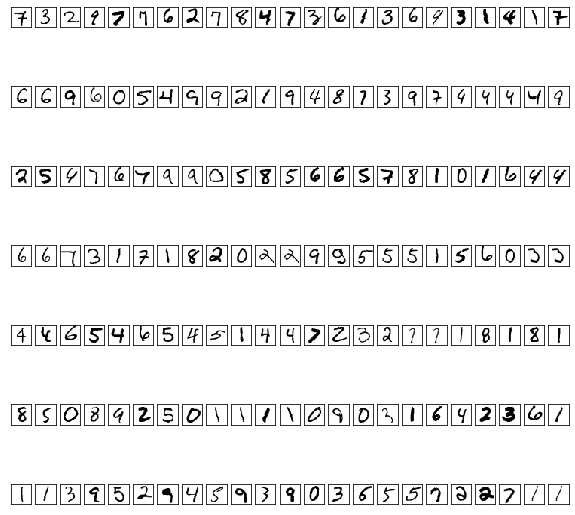

In [508]:
plt.figure(figsize=(10, 10))

for i in range(len(d_imgs)):
    plt.subplot(7, 23 , i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(d_imgs[i].reshape(28, 28), cmap = plt.cm.binary)